## Imports

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.models import densenet121
from timm import create_model
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.models import vit_b_16
from tqdm import tqdm
from sklearn.metrics import f1_score
from scipy.optimize import minimize
import random
from collections import defaultdict
import ast


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
images_folder = "/home/annachatz/Deep Learning/multilabel_modified/images/"
csv_file = "/home/annachatz/Deep Learning/multilabel_modified/multilabel_classification.csv"

# Load CSV
df = pd.read_csv(csv_file)

> **Note:**  
> We dropped rows containing `'desert'` in `Column2` because this value only appears in the column headers and not in the actual data. This helps ensure the data is clean and accurate for further analysis.


In [39]:
df = df[~df['Column2'].str.contains('desert', na=False)]

# Step 2: Reset the index
df.reset_index(drop=True, inplace=True)

In [ ]:
df

,Column1,Column2
0,Image_Name,Classes
1,image0.jpg,
2,image1.jpg,bus person
3,image2.jpg,sitar
4,image3.jpg,flutes
...,...,...
8562,image8964.img,trees
8563,image8965.img,trees
8564,image8966.img,trees
8565,image8967.img,trees


## Data Cleaning and Label Encoding Steps

1. **Filter Rows**  
   - Removed rows where `Column1` ends with `.img`.
   - Kept only rows where `Column1` contains `.jpg`, `Column2` is not empty, and `Column2` is not `'desert'`.

2. **Process the Labels Column**  
   - Split the values in `Column2` by spaces to create a list of labels for each image.

3. **Multi-Label Binarization**  
   - Used `MultiLabelBinarizer` to convert label lists into one-hot encoded columns.

4. **Add Encoded Labels**  
   - Added new columns for each label, with binary values indicating presence (1) or absence (0).

5. **Rename Columns**  
   - Renamed `Column1` to `'Image Name'` and `Column2` to `'Labels'` for clarity.


In [ ]:
# 1. Filter rows
df = df[~df['Column1'].str.endswith('.img', na=False)]
df.reset_index(drop=True, inplace=True)
df = df[
    (df['Column1'].str.contains('.jpg', na=False)) &
    (df['Column2'].str.strip() != '') &
    (df['Column2'] != 'desert')
]

# 2. Process the Labels column
df['Column2'] = df['Column2'].apply(lambda x: [label.strip() for label in x.split() if label.strip()] if isinstance(x, str) else [])

# 3. Multi-label binarizer to encode labels
mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(df['Column2'])

# 4. Add encoded labels as separate columns
label_columns = mlb.classes_
for idx, label in enumerate(label_columns):
    df[label] = encoded_labels[:, idx]

# 5. Rename Columns
df = df.rename(columns={'Column1': 'Image Name', 'Column2': 'Labels'})



In [42]:
df

,Image Name,Labels,boat,bus,cycle,ektara,flutes,harmonium,motorcycle,mountains,person,sea,sitar,sunset,tabla,trees,truck
2,image1.jpg,"[bus, person]",0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,image2.jpg,[sitar],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,image3.jpg,[flutes],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,image4.jpg,"[bus, trees]",0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
6,image5.jpg,[bus],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6970,image6964.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6971,image6965.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6972,image6966.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6973,image6967.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [43]:
# Drop rows where the image path doesn't exist
df['full_path'] = df['Image Name'].apply(lambda x: os.path.join(images_folder, x))
df = df[df['full_path'].apply(os.path.exists)].reset_index(drop=True)


In [44]:
df

,Image Name,Labels,boat,bus,cycle,ektara,flutes,harmonium,motorcycle,mountains,person,sea,sitar,sunset,tabla,trees,truck,full_path
0,image1.jpg,"[bus, person]",0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
1,image2.jpg,[sitar],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
2,image3.jpg,[flutes],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
3,image4.jpg,"[bus, trees]",0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,/home/annachatz/Deep Learning/multilabel_modif...
4,image5.jpg,[bus],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6961,image6964.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...
6962,image6965.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...
6963,image6966.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...
6964,image6967.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...


## Train/Validation/Test Split

- **Step 1:** Split the main DataFrame into `train_df` (70%) and a temporary set (`temp_df`, 30%) using `train_test_split` with shuffling for randomness and a fixed `random_state` for reproducibility.
- **Step 2:** Further split `temp_df` equally into `val_df` (15% of original) and `test_df` (15% of original), again with shuffling and the same random seed.

This ensures a 70/15/15 split between training, validation, and test sets.


In [97]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

# Step 2: Split temp into val and dev
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

## Dataset and DataLoader Preparation

- **`MultiLabelDataset`**:  
  Wraps the training and validation data, applying a simple image transform pipeline.
  - Images are resized to 224×224, converted to tensors, and normalized with standard ImageNet statistics.
- **Train/Validation Datasets**:  
  - `train_dataset`: Uses the training DataFrame and transformation.
  - `val_dataset`: Uses the validation DataFrame and transformation.
- **DataLoaders**:  
  - `train_loader`: Loads batches of 32 training samples with shuffling.
  - `val_loader`: Loads batches of 32 validation samples without shuffling.


In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = dataframe.drop(columns=['Image Name', 'Labels', 'full_path']).values
        self.img_paths = dataframe['full_path'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        labels = torch.from_numpy(np.array(self.labels[idx], dtype=np.float32))

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, labels


In [99]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Just resize
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard normalization
                         std=[0.229, 0.224, 0.225]),
])

In [100]:
train_dataset = MultiLabelDataset(train_df, transform=simple_transform)
val_dataset = MultiLabelDataset(val_df, transform=simple_transform)

In [101]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define Model

In [ ]:
print(label_columns)

array(['boat', 'bus', 'cycle', 'ektara', 'flutes', 'harmonium',
       'motorcycle', 'mountains', 'person', 'sea', 'sitar', 'sunset',
       'tabla', 'trees', 'truck'], dtype=object)

In [ ]:
num_classes = len(label_columns) 

## Model Setup: ResNet50 for Multi-Label Classification
**Base Architecture:**  
- **ResNet50** is a widely used deep convolutional neural network with 50 layers.
- It uses *residual connections* (skip connections) that allow gradients to flow directly through the network, making it possible to train very deep architectures effectively.
- The original model ends with a fully connected (fc) layer that outputs 1,000 logits (for ImageNet’s 1,000 classes).

**Modification for Multi-Label Tasks:**  
- For multi-label image classification, we need the model to predict the presence or absence of each label independently for every image.
- To do this, we *replace the final fc layer* with a new one:
  ```python
  model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
model = resnet50(pretrained=True)

# Replace the final layer to match the number of labels
num_classes = len(label_columns)  # Number of unique labels in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust output layer

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Loss function
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Model Training and Validation Loop

- **Training Loop:**  
  - For a set number of epochs (`num_epochs`), the model is set to training mode.
  - Each batch from the training DataLoader is sent to the device.
  - Gradients are zeroed, and a forward pass computes model outputs.
  - The loss (using the chosen criterion, e.g., BCEWithLogitsLoss for multi-label classification) is computed and backpropagated.
  - Model parameters are updated with the optimizer.
  - The average training loss for each epoch is printed.

- **Validation Phase:**  
  - After each training epoch, the model is switched to evaluation mode (disabling dropout, etc.).
  - The validation DataLoader is used to calculate the average validation loss without updating the model weights.

- **Model Saving:**  
  - After training, the model’s weights are saved to a `.pth` file for future use or further fine-tuning.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'resnet50.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1415
Validation Loss: 0.0721
Epoch [2/5], Loss: 0.0634
Validation Loss: 0.0667
Epoch [3/5], Loss: 0.0438
Validation Loss: 0.0739
Epoch [4/5], Loss: 0.0337
Validation Loss: 0.0758
Epoch [5/5], Loss: 0.0249
Validation Loss: 0.0694
Model saved successfully!


In [ ]:
# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.98      0.98       214
         bus       0.98      0.88      0.93       113
       cycle       0.99      0.97      0.98       220
      ektara       0.95      0.84      0.89        25
      flutes       0.88      0.96      0.92        23
   harmonium       0.89      0.82      0.85        39
  motorcycle       0.98      0.97      0.98       188
   mountains       0.70      0.58      0.64        24
      person       0.86      0.77      0.81       341
         sea       0.98      0.95      0.97       218
       sitar       0.69      0.85      0.76        34
      sunset       0.64      0.64      0.64        11
       tabla       0.98      0.94      0.96       115
       trees       0.81      0.69      0.75       206
       truck       0.93      0.97      0.95       127

   micro avg       0.93      0.88      0.90      1898
   macro avg       0.88      0.85      0.87      1898
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This function visualizes a batch of validation images alongside their ground truth and predicted labels.


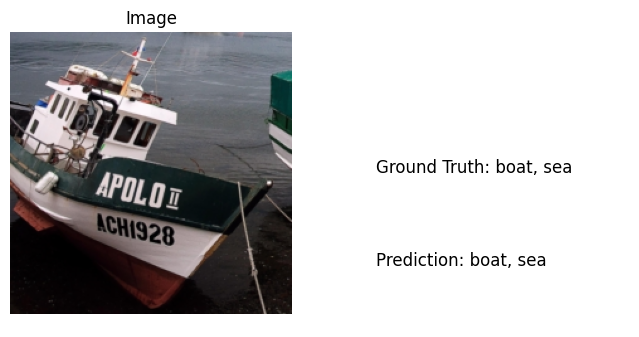

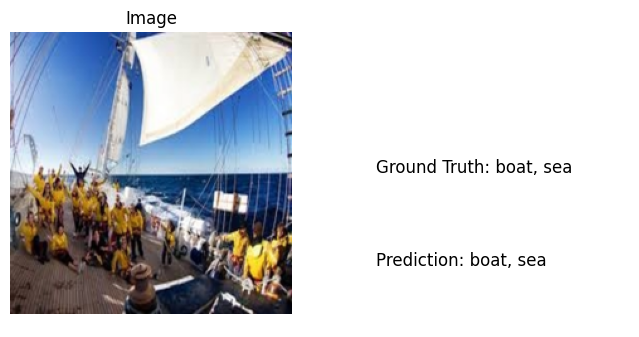

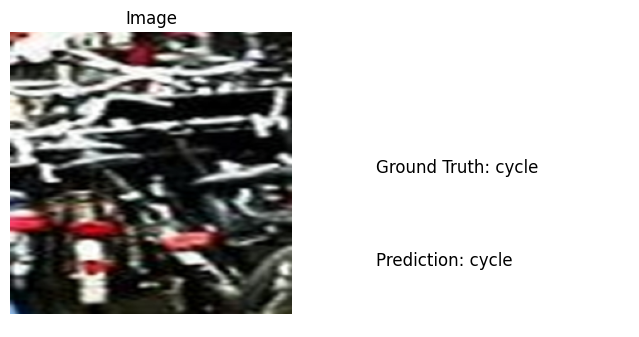

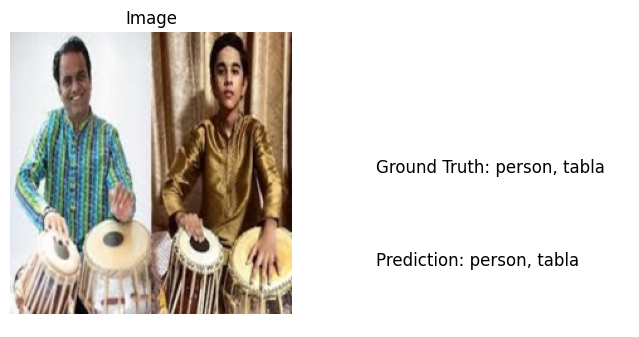

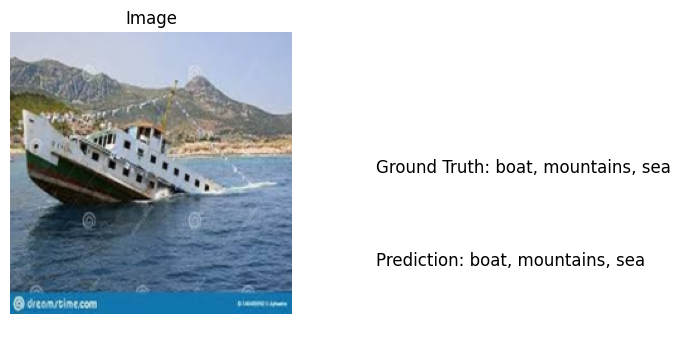

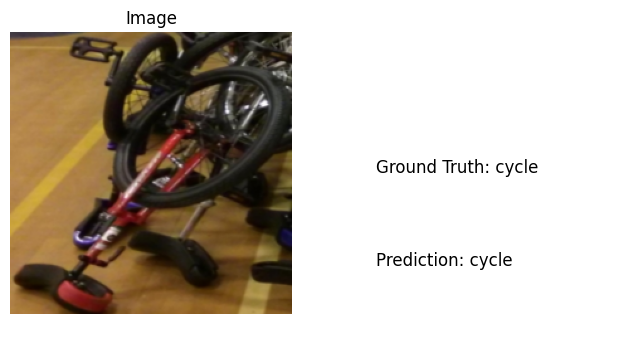

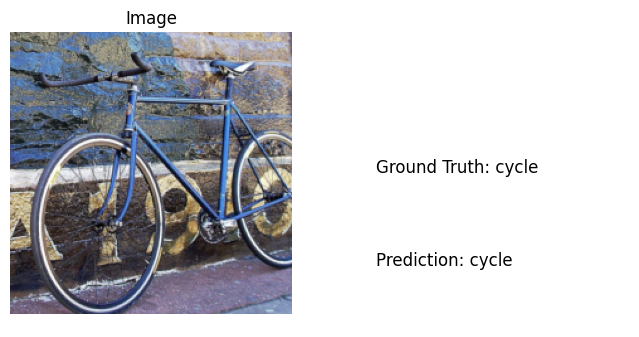

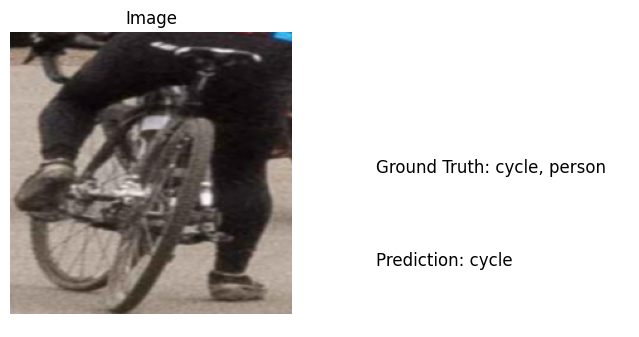

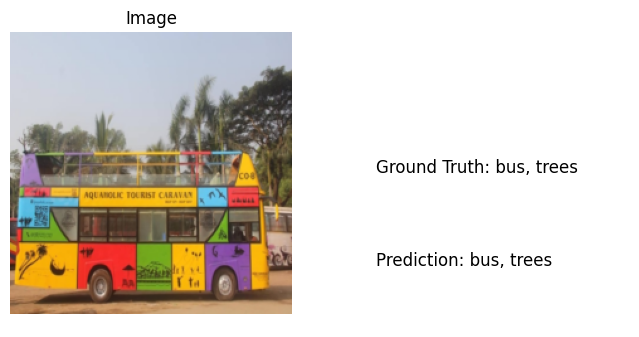

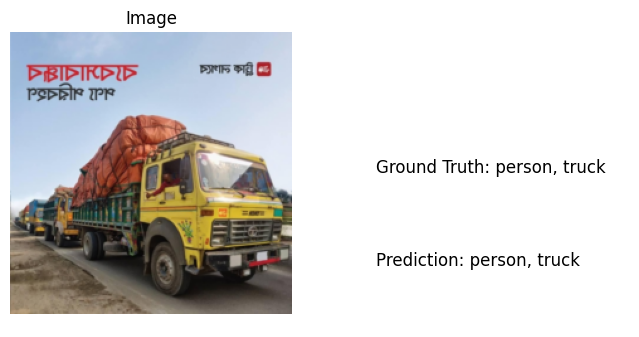

In [ ]:
# Helper function to unnormalize an image
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img.clone()
    img = img * std[:, None, None] + mean[:, None, None]
    return img

# Helper function to plot images with predictions and ground truth
def plot_predictions(model, data_loader, label_columns, device):
    model.eval()
    images, labels = next(iter(data_loader))  # Get a batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold for binary predictions

    # Select a few examples to visualize
    num_examples = min(10, len(images))
    images = images[:num_examples].cpu()
    labels = labels[:num_examples].cpu()
    predictions = predictions[:num_examples].cpu()

    for i in range(num_examples):
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        img = unnormalize(images[i])
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image")

        plt.subplot(1, 2, 2)
        true_labels = [label_columns[j] for j, val in enumerate(labels[i]) if val == 1]
        pred_labels = [label_columns[j] for j, val in enumerate(predictions[i]) if val == 1]
        plt.text(0.1, 0.5, f"Ground Truth: {', '.join(true_labels)}", fontsize=12)
        plt.text(0.1, 0.2, f"Prediction: {', '.join(pred_labels)}", fontsize=12)
        plt.axis('off')

        plt.show()

plot_predictions(model, val_loader, label_columns, device)


## Using EfficientNet-B0 for Multi-Label Classification

- **EfficientNet-B0 Architecture:**  
  EfficientNet is a family of convolutional neural networks known for achieving high accuracy with fewer parameters and computations. EfficientNet-B0, the smallest model in the series, uses a combination of depthwise separable convolutions and a compound scaling method to balance network depth, width, and input resolution efficiently.
  
- **Modification for Multi-Label Output:**  
  The original final classification layer (`classifier`) is replaced to match the number of unique labels in our dataset:
  ```python
  model.classifier = nn.Linear(model.classifier.in_features, num_classes)


In [ ]:
model = create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'aug_efficientb0.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.2601
Validation Loss: 0.0992
Epoch [2/5], Loss: 0.1001
Validation Loss: 0.0739
Epoch [3/5], Loss: 0.0690
Validation Loss: 0.0675
Epoch [4/5], Loss: 0.0525
Validation Loss: 0.0670
Epoch [5/5], Loss: 0.0388
Validation Loss: 0.0690
Model saved successfully!


In [ ]:
# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.98      0.99       214
         bus       0.97      0.96      0.96       113
       cycle       1.00      0.96      0.98       220
      ektara       0.87      0.80      0.83        25
      flutes       0.76      0.96      0.85        23
   harmonium       0.77      0.85      0.80        39
  motorcycle       0.98      0.96      0.97       188
   mountains       0.70      0.29      0.41        24
      person       0.87      0.76      0.81       341
         sea       0.98      0.94      0.96       218
       sitar       0.74      0.82      0.78        34
      sunset       0.64      0.64      0.64        11
       tabla       0.92      0.94      0.93       115
       trees       0.83      0.75      0.79       206
       truck       0.97      0.98      0.97       127

   micro avg       0.93      0.88      0.90      1898
   macro avg       0.87      0.84      0.84      1898
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using DenseNet-121 for Multi-Label Classification

- **DenseNet-121 Architecture:**  
  DenseNet-121 is a deep convolutional neural network characterized by its *dense connectivity*: each layer receives input from all preceding layers and passes its own feature maps to all subsequent layers within a block. This design encourages feature reuse, improves information flow, and helps mitigate the vanishing gradient problem in deep networks. The “121” refers to the total number of layers in the model.

- **Modification for Multi-Label Output:**  
  The original classification layer (`classifier`) is replaced to match the number of labels in our dataset:
  ```python
  model.classifier = nn.Linear(model.classifier.in_features, num_classes)


In [28]:
model = densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), 'densenet121.pth')
print("Model saved successfully!")


Epoch [1/5], Loss: 0.2090
Validation Loss: 0.0980
Epoch [2/5], Loss: 0.0834
Validation Loss: 0.0742
Epoch [3/5], Loss: 0.0583
Validation Loss: 0.0665
Epoch [4/5], Loss: 0.0422
Validation Loss: 0.0635
Epoch [5/5], Loss: 0.0337
Validation Loss: 0.0681
Model saved successfully!


In [110]:
# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.99      0.99       214
         bus       0.98      0.93      0.95       113
       cycle       1.00      0.96      0.98       220
      ektara       0.95      0.80      0.87        25
      flutes       0.88      0.96      0.92        23
   harmonium       0.97      0.79      0.87        39
  motorcycle       1.00      0.95      0.98       188
   mountains       0.82      0.38      0.51        24
      person       0.91      0.73      0.81       341
         sea       0.99      0.96      0.97       218
       sitar       0.76      0.82      0.79        34
      sunset       0.58      0.64      0.61        11
       tabla       0.94      0.97      0.95       115
       trees       0.80      0.80      0.80       206
       truck       0.95      0.97      0.96       127

   micro avg       0.94      0.89      0.91      1898
   macro avg       0.90      0.84      0.86      1898
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using ViT-B/16 (Vision Transformer) for Multi-Label Classification

- **ViT-B/16 Architecture:**  
  Vision Transformer (ViT-B/16) is a deep learning model that applies transformer architectures—originally designed for natural language processing—to images. It splits each image into 16×16 pixel patches, flattens them, and treats each patch as a “token” (like a word in a sentence). These tokens are then processed by transformer encoder blocks that use self-attention to learn global relationships between image regions, enabling strong representation learning without convolutional layers. The “B/16” means “Base” size (12 layers) and patch size 16.

- **Modification for Multi-Label Output:**  
  The final classification head (`model.heads.head`) is replaced with a new fully connected layer:
  ```python
  model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)


In [ ]:
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), 'vit.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1310
Validation Loss: 0.0823
Epoch [2/5], Loss: 0.0626
Validation Loss: 0.0721
Epoch [3/5], Loss: 0.0449
Validation Loss: 0.0721
Epoch [4/5], Loss: 0.0345
Validation Loss: 0.0651
Epoch [5/5], Loss: 0.0255
Validation Loss: 0.0643
Model saved successfully!


In [114]:
# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.96      0.98       214
         bus       0.94      0.98      0.96       113
       cycle       0.99      0.95      0.97       220
      ektara       0.92      0.88      0.90        25
      flutes       0.88      0.96      0.92        23
   harmonium       0.89      0.85      0.87        39
  motorcycle       0.96      0.97      0.97       188
   mountains       0.76      0.54      0.63        24
      person       0.91      0.67      0.77       341
         sea       0.99      0.94      0.96       218
       sitar       0.84      0.76      0.80        34
      sunset       0.47      0.73      0.57        11
       tabla       1.00      0.92      0.96       115
       trees       0.79      0.82      0.80       206
       truck       0.99      0.91      0.95       127

   micro avg       0.93      0.87      0.90      1898
   macro avg       0.89      0.86      0.87      1898
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using DeiT-base/16 for Multi-Label Classification

- **DeiT-base/16 Architecture:**  
  DeiT (Data-efficient Image Transformer) is a vision transformer designed to work well with less training data and without requiring huge labeled datasets. Like ViT, DeiT splits input images into 16×16 patches, embeds them as tokens, and processes them through multiple transformer encoder layers using self-attention. DeiT introduces innovative training strategies (such as knowledge distillation with a “distillation token”) to improve performance and data efficiency.

- **Modification for Multi-Label Output:**  
  The original final classification layer (`head`) is replaced to support multi-label outputs:
  ```python
  model.head = nn.Linear(model.head.in_features, num_classes)


In [34]:
model = create_model('deit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), 'deit.pth')
print("Model saved successfully!")


Epoch [1/5], Loss: 0.1172
Validation Loss: 0.0670
Epoch [2/5], Loss: 0.0475
Validation Loss: 0.0578
Epoch [3/5], Loss: 0.0289
Validation Loss: 0.0564
Epoch [4/5], Loss: 0.0204
Validation Loss: 0.0599
Epoch [5/5], Loss: 0.0159
Validation Loss: 0.0647
Model saved successfully!


In [18]:
# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.98      0.99       214
         bus       0.97      0.93      0.95       113
       cycle       0.99      0.97      0.98       220
      ektara       0.95      0.80      0.87        25
      flutes       0.79      0.96      0.86        23
   harmonium       0.80      0.90      0.84        39
  motorcycle       0.99      0.95      0.97       188
   mountains       0.83      0.62      0.71        24
      person       0.92      0.71      0.80       341
         sea       0.97      0.98      0.97       218
       sitar       0.74      0.85      0.79        34
      sunset       0.62      0.73      0.67        11
       tabla       0.96      0.98      0.97       115
       trees       0.84      0.80      0.82       206
       truck       0.95      0.98      0.97       127

   micro avg       0.94      0.89      0.92      1898
   macro avg       0.89      0.88      0.88      1898
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Ensemble Prediction with Multiple Models

- **Ensemble Setup:**  
  We combine several independently trained models (ResNet, DenseNet, EfficientNet, ViT, DeiT) to make predictions as a group, rather than relying on a single model. Model ensembles reduce variance and can help compensate for the individual weaknesses of each architecture, often improving overall accuracy and generalization on unseen data.

- **How the Ensemble Works:**  
  - For each input batch, all models in the list are used to make predictions.
  - Each model outputs multi-label logits, which are passed through a sigmoid to get probability scores for each class.
  - The predictions from all models are stacked and then averaged across models to produce a final consensus prediction for each label.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_columns) 

# Load ResNet
resnet = resnet50(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
resnet.load_state_dict(torch.load('resnet50.pth'))
resnet.to(device)
resnet.eval()

# Load DenseNet
densenet = densenet121(pretrained=False)
densenet.classifier = torch.nn.Linear(densenet.classifier.in_features, num_classes)
densenet.load_state_dict(torch.load('densenet121.pth'))
densenet.to(device)
densenet.eval()

# Load EfficientNet
efficientnet = create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
efficientnet.load_state_dict(torch.load('efficientb0.pth'))
efficientnet.to(device)
efficientnet.eval()

# Load ViT
vit = vit_b_16(pretrained=False)  # no need pretrained, since you are loading your weights
vit.heads.head = torch.nn.Linear(vit.heads.head.in_features, num_classes)
vit.load_state_dict(torch.load('vit.pth'))
vit.to(device)
vit.eval()

# Load DeiT
deit = create_model('deit_base_patch16_224', pretrained=False, num_classes=num_classes)
deit.load_state_dict(torch.load('deit.pth'))
deit.to(device)
deit.eval()


/tmp/ipykernel_3552825/3160056486.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('resnet50.pth'))
/tmp/ipykernel_3552825/3160056486.p

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
models = [resnet, densenet, efficientnet, vit, deit]

In [40]:
def ensemble_predict(models, images):
    outputs = []
    for model in models:
        with torch.no_grad():
            out = model(images)
            outputs.append(torch.sigmoid(out))  # Apply sigmoid for multi-label

    outputs = torch.stack(outputs, dim=0)  # (num_models, batch_size, num_classes)
    outputs = outputs.mean(dim=0)           # Average over models
    return outputs


In [ ]:
all_labels = []
all_predictions = []

for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction
    outputs = ensemble_predict(models, images)

    predictions = (outputs > 0.5).float()  # Apply 0.5 threshold

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

# Stack all the results
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Print classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.99      0.99       214
         bus       0.96      0.93      0.95       113
       cycle       1.00      0.98      0.99       220
      ektara       0.95      0.84      0.89        25
      flutes       0.92      0.96      0.94        23
   harmonium       0.92      0.87      0.89        39
  motorcycle       1.00      0.96      0.98       188
   mountains       0.82      0.38      0.51        24
      person       0.90      0.77      0.83       341
         sea       0.99      0.98      0.98       218
       sitar       0.82      0.82      0.82        34
      sunset       0.70      0.64      0.67        11
       tabla       0.96      0.97      0.97       115
       trees       0.83      0.80      0.81       206
       truck       0.98      0.98      0.98       127

   micro avg       0.95      0.90      0.92      1898
   macro avg       0.92      0.86      0.88      1898
weighted avg       0.95   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Ensemble Prediction with Majority Voting

- **Majority Voting Ensemble:**  
  Instead of averaging probabilities, this approach combines the binary predictions from each model by letting each model “vote” on the presence or absence of each label.
  
- **How It Works:**  
  1. Each model predicts a binary (0 or 1) label for each class using a sigmoid threshold.
  2. The predictions from all models are stacked and summed.
  3. For each class, if at least half of the models predict a label as present (votes ≥ 50%), the final prediction for that label is set to 1 (present); otherwise, it is 0 (absent).



In [42]:
def ensemble_predict_majority_vote(models, images):
    all_preds = []
    for model in models:
        with torch.no_grad():
            out = model(images)
            out = torch.sigmoid(out)  # Turn logits into probabilities
            pred = (out > 0.5).float()  # Convert to binary (0 or 1)
            all_preds.append(pred)

    # Stack all predictions: shape (num_models, batch_size, num_classes)
    all_preds = torch.stack(all_preds, dim=0)

    # Sum across models
    votes = all_preds.sum(dim=0)

    # If votes >= half models → final prediction is 1
    majority_threshold = len(models) / 2
    final_preds = (votes >= majority_threshold).float()

    return final_preds


In [43]:
all_labels = []
all_predictions = []

for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)

    # Ensemble prediction with majority voting
    predictions = ensemble_predict_majority_vote(models, images)

    all_labels.append(labels.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.99      0.99      0.99       214
         bus       0.97      0.94      0.95       113
       cycle       1.00      0.97      0.99       220
      ektara       0.95      0.84      0.89        25
      flutes       0.85      0.96      0.90        23
   harmonium       0.92      0.87      0.89        39
  motorcycle       1.00      0.96      0.98       188
   mountains       0.82      0.38      0.51        24
      person       0.90      0.77      0.83       341
         sea       0.99      0.98      0.98       218
       sitar       0.77      0.79      0.78        34
      sunset       0.70      0.64      0.67        11
       tabla       0.95      0.97      0.96       115
       trees       0.82      0.79      0.80       206
       truck       0.99      0.97      0.98       127

   micro avg       0.94      0.90      0.92      1898
   macro avg       0.91      0.85      0.87      1898
weighted avg       0.94   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Optimizing Ensemble Weights for Multi-Label Prediction

- **Collecting Model Outputs:**  
  - For each batch in the validation set, raw (sigmoid) prediction probabilities from each model are stored, as well as the true labels.
  - This allows post-hoc combination and analysis of different ensemble strategies.

- **Weighted Ensemble:**  
  - Instead of treating all models equally, this method finds the optimal weights for each model’s output when combining their predictions.
  - For a given set of weights, each model’s probabilities are multiplied by its weight and summed.
  - A fixed threshold (e.g., 0.5) is applied to convert the weighted sum into binary predictions.

- **Performance Metric:**  
  - The **macro F1 score** (which gives equal importance to each class) is computed between the weighted ensemble predictions and the ground truth labels.
  - The function returns the negative F1 score so that optimization algorithms (like `scipy.optimize.minimize`) can maximize F1 by minimizing its negative.
---

**Conclusion:**  
After optimization, the best performance was achieved when all five models were given equal weights (0.2 each). This suggests that each model contributes similarly and that a simple average of their predictions is the most effective strategy for this ensemble on the validation set.


In [ ]:
# Collect raw outputs from each model
raw_outputs = [[] for _ in range(len(models))]
all_labels = []

for images, labels in tqdm(val_loader):
    images, labels = images.to(device), labels.to(device)

    for i, model in enumerate(models):
        with torch.no_grad():
            out = torch.sigmoid(model(images))  # (batch_size, num_classes)
            raw_outputs[i].append(out.cpu().numpy())

    all_labels.append(labels.cpu().numpy())

raw_outputs = [np.vstack(out) for out in raw_outputs]  # List of arrays (n_samples, n_classes)
all_labels = np.vstack(all_labels)  # (n_samples, n_classes)


100%|██████████| 33/33 [00:13<00:00,  2.37it/s]


In [ ]:
def evaluate_weights(weights, raw_outputs, true_labels, threshold=0.5):
    # weighted sum
    weighted_output = np.zeros_like(raw_outputs[0])
    for w, out in zip(weights, raw_outputs):
        weighted_output += w * out

    # Apply threshold
    preds = (weighted_output > threshold).astype(int)

    # Calculate Macro F1 score (multi-label setting)
    f1 = f1_score(true_labels, preds, average='macro')
    return -f1  # Minimize -f1 => maximize f1


In [46]:
# Start with equal weights
initial_weights = np.ones(len(models)) / len(models)

# Constraint: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})

# Bounds: each weight between 0 and 1
bounds = [(0, 1)] * len(models)

# Run optimizer
result = minimize(evaluate_weights,
                  initial_weights,
                  args=(raw_outputs, all_labels),
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)

# Best found weights
best_weights = result.x

print("Best Ensemble Weights:", best_weights)


Best Ensemble Weights: [0.2 0.2 0.2 0.2 0.2]


## Label Distribution in the Training Set

The bar plot below shows the frequency of each label in the training data. As seen in the plot, some labels are much less common (rare) than others, which could make it challenging for the model to learn to predict these underrepresented classes.

**To address this class imbalance, we will apply targeted data augmentation strategies to increase the representation of rare labels in the training set and help improve the model's ability to generalize to all classes.**


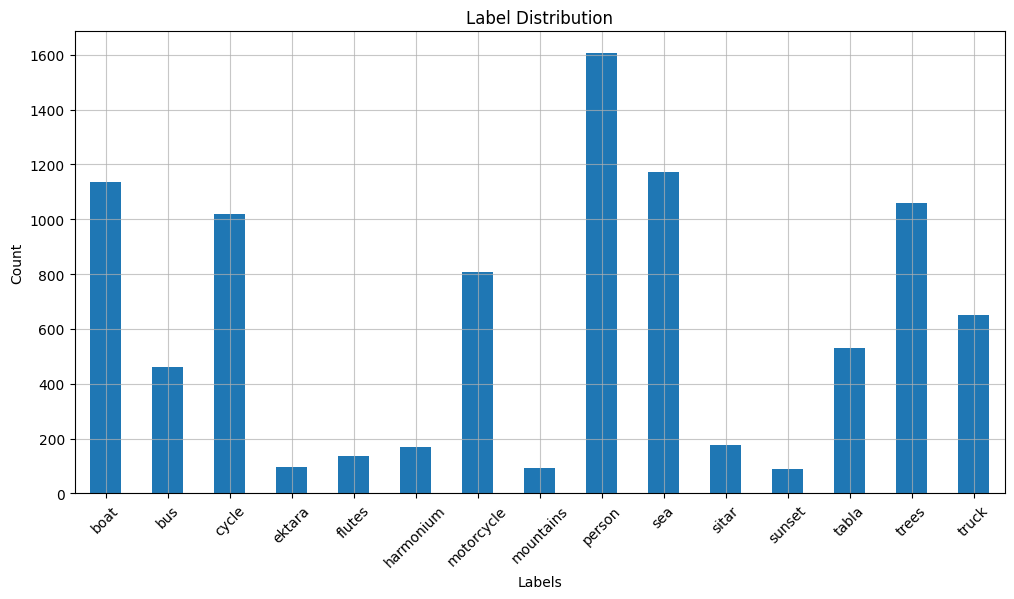

In [16]:
label_counts = train_df[label_columns].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(alpha=0.7)
plt.savefig("label_distribution.png", dpi=300)
plt.show()


In [25]:
df

,Image Name,Labels,boat,bus,cycle,ektara,flutes,harmonium,motorcycle,mountains,person,sea,sitar,sunset,tabla,trees,truck,full_path
0,image1.jpg,"[bus, person]",0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
1,image2.jpg,[sitar],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
2,image3.jpg,[flutes],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
3,image4.jpg,"[bus, trees]",0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,/home/annachatz/Deep Learning/multilabel_modif...
4,image5.jpg,[bus],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6961,image6964.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...
6962,image6965.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...
6963,image6966.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...
6964,image6967.jpg,"[truck, trees]",0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,/home/annachatz/Deep Learning/multilabel_modif...


## Addressing Class Imbalance with Targeted Data Augmentation

- **Goal:**  
  To increase the number of training samples for rare (underrepresented) labels and improve the model’s ability to learn these classes.

  1. **Identify Underrepresented Labels:**  
     - Finds all labels that appear fewer than a set threshold (e.g., 200 times) in the training set.
  2. **Collect Source Images:**  
     - For each underrepresented label, gathers all images containing that label.
  3. **Apply Augmentations:**  
     - Generates new synthetic images by randomly applying augmentations such as flips, rotations, color jitter, and random crops to images with rare labels.
     - Augmentation continues for each rare label until it has at least a target number of samples (e.g., 400).
  4. **Save Augmented Data:**  
     - Each new image is saved to disk with a unique name, and its metadata (including label information and file path) is added to a new DataFrame.
     - One-hot encoding is applied to the labels for compatibility with the training pipeline.
  5. **Export the Combined Dataset:**  
     - The augmented samples are combined with the original training set and saved as a new CSV file for downstream training.

- **Result:**  
  The training dataset now has a more balanced distribution of labels, which should help the model learn to recognize rare classes more effectively.


In [ ]:
# Paths
image_dir = "/home/annachatz/Deep Learning/multilabel_modified/images/"
csv_path = "/home/annachatz/Deep Learning/multilabel_modified/multilabel_classification.csv"
output_dir = os.path.join(image_dir, "augmented")
os.makedirs(output_dir, exist_ok=True)

train_df['Labels'] = train_df['Labels'].apply(lambda x: x if isinstance(x, list) else ast.literal_eval(x))

# Count label frequencies
label_counts = defaultdict(int)
for labels in train_df['Labels']:
    for label in labels:
        label_counts[label] += 1

# Select underrepresented classes
min_required = 400
threshold = 200
underrepresented = {label for label, count in label_counts.items() if count < threshold}
print("Underrepresented labels:", underrepresented)

# Map label to image samples
label_to_images = defaultdict(list)
for idx, row in train_df.iterrows():
    for label in row['Labels']:
        if label in underrepresented:
            label_to_images[label].append(row)

# Define augmentation transforms
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
to_pil = transforms.ToPILImage()

# Generate augmented images
augmented_rows = []
for label in underrepresented:
    samples = label_to_images[label]
    current_count = label_counts[label]
    i = 0
    pbar = tqdm(total=min_required - current_count, desc=f"Augmenting '{label}'")

    while label_counts[label] < min_required:
        sample_row = random.choice(samples)
        img_name = sample_row['Image Name']
        labels = sample_row['Labels']
        img_path = sample_row['full_path']

        try:
            image = Image.open(img_path).convert('RGB')
            aug_image = to_pil(augmentation(image))

            new_name = f"aug_{label}_{i}_{img_name}"
            aug_image_path = os.path.join(output_dir, new_name)
            aug_image.save(aug_image_path)

            # Create row with all columns
            row_data = {
                'Image Name': new_name,
                'Labels': labels,
                'full_path': aug_image_path
            }

            # One-hot encoding
            for col in train_df.columns:
                if col not in ['Image Name', 'Labels', 'full_path']:
                    row_data[col] = 1 if col in labels else 0

            augmented_rows.append(row_data)

            for lbl in labels:
                label_counts[lbl] += 1

            i += 1
            pbar.update(1)
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")
    pbar.close()

# Combine and save
augmented_df = pd.DataFrame(augmented_rows)
combined_df = pd.concat([train_df, augmented_df], ignore_index=True)
augmented_csv_path = csv_path.replace(".csv", "_augmented.csv")
combined_df.to_csv(augmented_csv_path, index=False)

print(f"✅ Augmentation complete. Augmented CSV saved as: {augmented_csv_path}")


Underrepresented labels: {'flutes', 'sitar', 'mountains', 'harmonium', 'sunset', 'ektara'}


Augmenting 'flutes':   5%|▍         | 13/262 [00:00<00:07, 33.83it/s]

Augmenting 'ektara': 100%|██████████| 249/249 [00:10<00:00, 24.17it/s]


✅ Augmentation complete. Augmented CSV saved as: /home/annachatz/Deep Learning/multilabel_modified/multilabel_classification_augmented.csv


In [80]:
combined_df = pd.concat([train_df, augmented_df], ignore_index=True)

In [81]:
train_df = combined_df

## Fine-Tuning ResNet50 with Augmented Data

- We load a pre-trained ResNet50 model to leverage its powerful feature extraction capabilities, gained from training on the large ImageNet dataset.
- The final classification layer is replaced so the model outputs the correct number of scores for our multi-label task.
- This model will be **fine-tuned using our augmented training dataset** (which now includes extra samples for underrepresented labels), helping it learn more robust and balanced representations for all classes.
- By combining transfer learning with targeted data augmentation, we aim to improve the model’s performance—especially for rare or minority classes.


In [ ]:
model = resnet50(pretrained=True)
# Replace the final layer to match the number of labels
num_classes = len(label_columns)  # Number of unique labels in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust output layer

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
train_df

,Image Name,Labels,boat,bus,cycle,ektara,flutes,harmonium,motorcycle,mountains,person,sea,sitar,sunset,tabla,trees,truck,full_path
0,image5771.jpg,"[motorcycle, trees]",0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,/home/annachatz/Deep Learning/multilabel_modif...
1,image2997.jpg,"[cycle, person]",0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
2,image3822.jpg,"[boat, sea]",1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
3,image2117.jpg,[cycle],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
4,image48.jpg,[tabla],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,/home/annachatz/Deep Learning/multilabel_modif...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6289,aug_ektara_244_image2064.jpg,[ektara],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
6290,aug_ektara_245_image2050.jpg,[ektara],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
6291,aug_ektara_246_image331.jpg,[ektara],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,/home/annachatz/Deep Learning/multilabel_modif...
6292,aug_ektara_247_image1940.jpg,"[person, ektara, tabla]",0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,/home/annachatz/Deep Learning/multilabel_modif...


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'data_aug_resnet50.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1437
Validation Loss: 0.0704
Epoch [2/5], Loss: 0.0649
Validation Loss: 0.0695
Epoch [3/5], Loss: 0.0454
Validation Loss: 0.0679
Epoch [4/5], Loss: 0.0332
Validation Loss: 0.0685
Epoch [5/5], Loss: 0.0280
Validation Loss: 0.0770
Model saved successfully!


In [89]:

# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       0.98      0.97      0.97       214
         bus       0.96      0.87      0.91       113
       cycle       1.00      0.93      0.96       220
      ektara       0.94      0.60      0.73        25
      flutes       0.73      0.96      0.83        23
   harmonium       0.85      0.72      0.78        39
  motorcycle       0.95      0.96      0.95       188
   mountains       0.82      0.38      0.51        24
      person       0.84      0.76      0.80       341
         sea       0.98      0.94      0.96       218
       sitar       0.78      0.82      0.80        34
      sunset       0.75      0.55      0.63        11
       tabla       0.93      0.97      0.94       115
       trees       0.82      0.79      0.81       206
       truck       0.85      0.97      0.91       127

   micro avg       0.91      0.87      0.89      1898
   macro avg       0.88      0.81      0.83      1898
weighted avg       0.91   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion: Impact of Data Augmentation

After evaluating the model’s performance on the validation set, we observed that data augmentation did **not** lead to improved results compared to training on the original dataset. As a result, we will not include data augmentation in our future experiments for this project.


## Fine-Tuning Strategy: Training All Layers

- **Full Fine-Tuning:**  
  - In this setup, **all parameters** of the ResNet50 model are set to `requires_grad = True`, meaning the entire network (not just the final layer) will be updated during training.
  - This contrasts with a *feature extraction* approach, where only the final classification layer is trained and all other layers are “frozen” (i.e., their weights do not change).

**Summary:**  
Instead of just training a new output layer, we are allowing the entire ResNet50 architecture to learn from scratch on our dataset, leveraging transfer learning but giving the model maximum flexibility to adjust all learned features.


In [104]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label_columns))  # Adjust output layer
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


torch.save(model.state_dict(), 'fine_resnet50.pth')
print("Model saved successfully!")

Epoch [1/5], Loss: 0.1501
Validation Loss: 0.0741
Epoch [2/5], Loss: 0.0642
Validation Loss: 0.0697
Epoch [3/5], Loss: 0.0442
Validation Loss: 0.0711
Epoch [4/5], Loss: 0.0333
Validation Loss: 0.0670
Epoch [5/5], Loss: 0.0254
Validation Loss: 0.0744
Model saved successfully!


In [106]:

# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.99      0.99       214
         bus       0.97      0.88      0.93       113
       cycle       0.99      0.97      0.98       220
      ektara       0.91      0.84      0.87        25
      flutes       0.92      0.96      0.94        23
   harmonium       0.92      0.87      0.89        39
  motorcycle       0.99      0.95      0.97       188
   mountains       0.71      0.42      0.53        24
      person       0.88      0.68      0.77       341
         sea       0.98      0.95      0.97       218
       sitar       0.82      0.82      0.82        34
      sunset       0.60      0.55      0.57        11
       tabla       0.96      0.96      0.96       115
       trees       0.76      0.78      0.77       206
       truck       0.88      0.98      0.93       127

   micro avg       0.92      0.87      0.90      1898
   macro avg       0.89      0.84      0.86      1898
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gradual Layer-Wise Fine-Tuning of ResNet50

- **Initial Freezing:**  
  - At the start, **all layers** of the ResNet50 model are frozen (`requires_grad = False`). This prevents their weights from being updated during training.
  - Only the final classification head (`fc`) and the last residual block (`layer4`) are unfrozen and trained initially. This focuses learning on the most task-specific layers, reducing overfitting and speeding up convergence.

- **Gradual Unfreezing:**  
  - At epoch 3, the previous block (`layer3`) is also unfrozen, allowing its weights to be updated for the remaining epochs.
  - The optimizer is updated at this point to include the new trainable parameters, and a lower learning rate (`1e-5`) is used to avoid disrupting previously learned weights.

- **Training Approach:**  
  - For the first few epochs, only a small subset of layers is trained, leveraging powerful pre-trained features in the early layers.
  - As training progresses, more of the network is fine-tuned, allowing deeper adaptation to the new dataset without immediately overfitting or destabilizing the model.

**Layer-wise fine-tuning** helps stabilize training, especially when the dataset is smaller or very different from ImageNet. It allows the model to adapt gradually, starting with the most relevant (higher) layers and progressively learning more specific features from the new data.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label_columns))
model = model.to(device)

# ----------------- Freeze all layers initially -----------------
for param in model.parameters():
    param.requires_grad = False

# ----------------- Unfreeze classifier and last block (layer4) -----------------
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# ----------------- Optimizer: only trainable params -----------------
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# ----------------- Loss -----------------
criterion = nn.BCEWithLogitsLoss()

num_epochs = 5

for epoch in range(num_epochs):
    # ----------------- Gradual unfreezing at epoch 3 -----------------
    if epoch == 3:
        print("Unfreezing layer3 for training...")
        for param in model.layer3.parameters():
            param.requires_grad = True
        # Update optimizer to include new parameters
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # ----------------- Validation -----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

# Save model
torch.save(model.state_dict(), 'fine_grad_resnet50.pth')
print("Model saved successfully!")


/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.1477
Validation Loss: 0.0742
Epoch [2/5], Loss: 0.0647
Validation Loss: 0.0676
Epoch [3/5], Loss: 0.0435
Validation Loss: 0.0651
Unfreezing layer3 for training...
Epoch [4/5], Loss: 0.0277
Validation Loss: 0.0625
Epoch [5/5], Loss: 0.0229
Validation Loss: 0.0627
Model saved successfully!


In [ ]:

# Predict on validation set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))  # Convert logits to probabilities
        predictions = (outputs > 0.5).float()  # Apply threshold
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

# Flatten the lists
all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)

# Generate classification report
print(classification_report(all_labels, all_predictions, target_names=label_columns))


              precision    recall  f1-score   support

        boat       1.00      0.98      0.99       214
         bus       0.97      0.92      0.95       113
       cycle       1.00      0.96      0.98       220
      ektara       0.91      0.84      0.87        25
      flutes       0.92      0.96      0.94        23
   harmonium       0.86      0.82      0.84        39
  motorcycle       0.99      0.98      0.98       188
   mountains       0.80      0.50      0.62        24
      person       0.86      0.77      0.81       341
         sea       0.99      0.95      0.97       218
       sitar       0.74      0.85      0.79        34
      sunset       0.75      0.55      0.63        11
       tabla       0.93      0.97      0.94       115
       trees       0.78      0.79      0.79       206
       truck       0.94      0.97      0.95       127

   micro avg       0.92      0.89      0.91      1898
   macro avg       0.90      0.85      0.87      1898
weighted avg       0.92   

/home/annachatz/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 